In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [15]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
  
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=(255, 0, 0), thickness=7):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [16]:
def separate_lines(lines):
    """ Takes an array of hough lines and separates them by +/- slope.
        The y-axis is inverted in matplotlib, so the calculated positive slopes will be right
        lane lines and negative slopes will be left lanes. """
    right = []
    left = []
    for x1,y1,x2,y2 in lines[:, 0]:
        m = (float(y2) - y1) / (x2 - x1)
        if m >= 0: 
            right.append([x1,y1,x2,y2,m])
        else:
            left.append([x1,y1,x2,y2,m])
    
    return right, left

In [17]:

def extend_point(x1, y1, x2, y2, length):
    """ Takes line endpoints and extroplates new endpoint by a specfic length"""
    line_len = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) 
    x = x2 + (x2 - x1) / line_len * length
    y = y2 + (y2 - y1) / line_len * length
    return x, y
  
def reject_outliers(data, cutoff, thresh=0.08):
    """Reduces jitter by rejecting lines based on a hard cutoff range and outlier slope """
    data = np.array(data)
    data = data[(data[:, 4] >= cutoff[0]) & (data[:, 4] <= cutoff[1])]
    m = np.mean(data[:, 4], axis=0)
    return data[(data[:, 4] <= m+thresh) & (data[:, 4] >= m-thresh)]


def merge_lines(lines):
    """Merges all Hough lines by the mean of each endpoint, 
       then extends them off across the image"""
    
    lines = np.array(lines)[:, :4] ## Drop last column (slope)
    
    x1,y1,x2,y2 = np.mean(lines, axis=0)
    x1e, y1e = extend_point(x1,y1,x2,y2, -1000) # bottom point
    x2e, y2e = extend_point(x1,y1,x2,y2, 1000)  # top point
    line = np.array([[x1e,y1e,x2e,y2e]])
    
    return np.array([line], dtype=np.int32)

In [18]:
def pipeline(image):  
    ### Params for region of interest
    bot_left = [80, 540]
    bot_right = [980, 540]
    apex_right = [510, 315]
    apex_left = [450, 315]
    v = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]
    
    ### Run canny edge detection and mask region of interest
    gray = grayscale(image)
    blur = gaussian_blur(gray, 3)
    edge = canny(blur, 25, 75)
    mask = region_of_interest(edge, v)
    
    ### Run Hough Lines and separate by +/- slope
    lines = cv2.HoughLinesP(mask, 0.8, np.pi/180, 25, np.array([]), minLineLength=100, maxLineGap=160)

    right_lines, left_lines = separate_lines(lines)
    right = reject_outliers(right_lines,  cutoff=(0.45, 0.75))
    right = merge_lines(right)
    
    left = reject_outliers(left_lines, cutoff=(-0.85, -0.6))
    left = merge_lines(left)

    lines = np.concatenate((right, left))
    
    ### Draw lines and return final image 
    line_img = np.copy((image)*0)
    draw_lines(line_img, lines, thickness=10)
    
    line_img = region_of_interest(line_img, v)
    final = weighted_img(line_img, image)
    

    return final

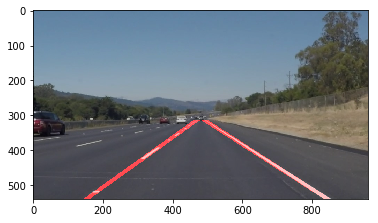

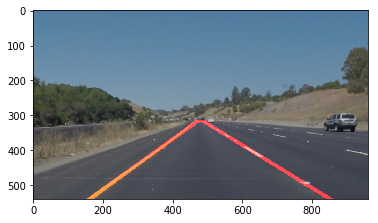

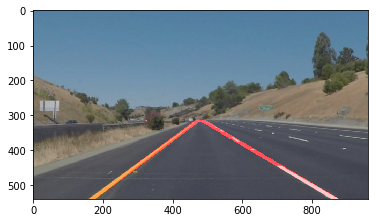

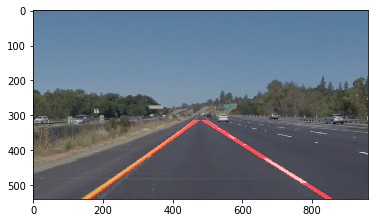

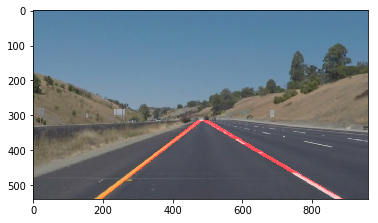

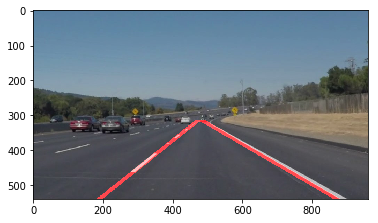

In [19]:
def display_image(image):
    plt.figure()
    plt.imshow(image, cmap='gray')
    

image = mpimg.imread('CarND-LaneLines-P1-master/test_images/solidWhiteRight.jpg')
processed_image = pipeline(image)
display_image(processed_image)

image = mpimg.imread('CarND-LaneLines-P1-master/test_images/solidYellowCurve.jpg')
processed_image = pipeline(image)
display_image(processed_image)

image = mpimg.imread('CarND-LaneLines-P1-master/test_images/solidYellowCurve2.jpg')
processed_image = pipeline(image)
display_image(processed_image)

image = mpimg.imread('CarND-LaneLines-P1-master/test_images/solidYellowLeft.jpg')
processed_image = pipeline(image)
display_image(processed_image)

image = mpimg.imread('CarND-LaneLines-P1-master/test_images/whiteCarLaneSwitch.jpg')
processed_image = pipeline(image)
display_image(processed_image)

image = mpimg.imread('CarND-LaneLines-P1-master/test_images/solidWhiteCurve.jpg')
processed_image = pipeline(image)
display_image(processed_image)


In [20]:
from moviepy.editor import VideoFileClip, ImageClip
from IPython.display import HTML

def process_image(image):
    result = pipeline(image)
    return result

white_output = 'white.mp4'
clip1 = VideoFileClip('CarND-LaneLines-P1-master/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('CarND-LaneLines-P1-master/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████▋| 221/222 [00:17<00:00,  8.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 20.3 s
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████▉| 681/682 [00:55<00:00,  5.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 57.7 s


In [21]:
#challenge 
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('CarND-LaneLines-P1-master/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████| 251/251 [00:49<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 54.3 s
